<a href="https://colab.research.google.com/github/Ssurf777/VAEforPointCloud/blob/main/main_for_ISABVQVAE_v2_(MSE).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

| Feature                         | PointNet Encoder                                            | Induced Set Attention Block (ISAB)                             |
|---------------------------------|-------------------------------------------------------------|-----------------------------------------------------------------|
| **Core Components**             | Pointwise (1D) Convolutions + Max Pooling                   | Multi-head Attention with Inducing Points                       |
| **Permutation Invariance**      | Achieved by Global Max Pooling                              | Achieved by Attention mechanism (order-independent)             |
| **Modeling Point Interactions** | Does **NOT** explicitly model point interactions (points processed independently) | **Explicitly models interactions** between points via Attention |
| **Hierarchical Information**    | Limited (Single-layer aggregation)                          | Capable of capturing **hierarchical structures** via two-step Attention |
| **Information Loss**            | High (Due to simple aggregation by max-pooling)             | Lower (Attention preserves detailed relationships)              |
| **Scalability & Efficiency**    | Very efficient and scalable                                 | Efficient with inducing points, though slightly more complex computationally |
| **Representation Richness**     | Limited (individual points aggregated simply)               | High (multiple attention heads capture diverse relations)       |
| **Impact on VAE Reconstruction Error** | Potentially higher (due to limited interaction modeling) | **Potentially lower** (due to capturing detailed structures)    |


https://www.hello-statisticians.com/ml/deeplearning/set_transformer1.html

In [1]:
!pip install POT

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 16.0 MB/s eta 0:00:00


In [2]:
import requests
import os

def download_file(url, local_filename):
    """Downloads a file from a URL to a local file."""
    print(f"Downloading {url}...")
    try:
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(local_filename, 'wb') as f:
                for chunk in r.iter_content(chunk_size=4096):  # Smaller chunk size
                    f.write(chunk)
        print(f"{local_filename} downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Failed to download {local_filename}: {e}")

# URLs for downloading
urls = {
    "utils.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/utils.py",
    "file_io.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/file_io.py",
    "point_cloud.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/point_cloud.py",
    "sampling.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/sampling.py",
    "ISAB_VQVAE.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/ISAB_VQVAE.py",
    "ISAB.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/ISAB.py",
    "ChamferDis.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/ChamferDis.py",
    "EarthMoversDis.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/EarthMoversDis.py",
    "train.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/train.py",
    "visualize_loss.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/visualize_loss.py",
    "Dataloader.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/Dataloader.py",
}

# Download each file
for local_filename, url in urls.items():
    download_file(url, local_filename)



utils.py downloaded successfully.
file_io.py downloaded successfully.
point_cloud.py downloaded successfully.
sampling.py downloaded successfully.
ISAB_VQVAE.py downloaded successfully.
ISAB.py downloaded successfully.
ChamferDis.py downloaded successfully.
EarthMoversDis.py downloaded successfully.
train.py downloaded successfully.
visualize_loss.py downloaded successfully.
Dataloader.py downloaded successfully.


In [3]:

# Import downloaded modules
import utils
import file_io
import point_cloud
import sampling
import ISAB_VQVAE
import ISAB
import ChamferDis
import EarthMoversDis
import train
import Dataloader
import visualize_loss
from utils import get_available_memory
from file_io import read_off
from point_cloud import pcshow
from sampling import PointSampler
from ISAB_VQVAE import ISAB_VQVAE
from ISAB import ISAB
from ChamferDis import chamfer_distance
from EarthMoversDis import emd_distance
from train import train
from visualize_loss import visualize_loss
from Dataloader import prepare_data_for_ISAB

available_memory_gb = get_available_memory()
print(f"Available memory: {available_memory_gb:.2f} GB")

Available memory: 10.79 GB


In [4]:
import torch
import torch.optim as optim
import numpy as np
import torch.nn.functional as F



device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_points =5000
# データ準備
file_names = [f"/content/drive/MyDrive/chair/chair_{i:04d}.off" for i in range(1, 10)]
data_loader = prepare_data_for_ISAB(file_names, num_points=num_points, device=device)
print(len(data_loader))
# VAEモデル構築
vae = ISAB_VQVAE(num_points=5000, dim_input=3, dim_hidden=128, num_heads=4, num_inds=32,embedding_dim=3, num_embeddings=32).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1.0e-4)

9


In [5]:
epochs=5000
interval=100
rec_error_record = []
reg_error_record = []   # ここでは量子化損失を "reg" と呼んで記録
total_error_record = []
z_list = []

for epoch in range(epochs):
    vae.train()
    running_rec_loss = 0.0
    running_quant_loss = 0.0
    running_total_loss = 0.0


    for batch_idx, (x,) in enumerate(data_loader):
        # -> [B, 3, 5000]
        x = x.permute(0, 2, 1).to(device)

        #print(f"x shape: {x.shape}")
        z, z_quantized, quant_loss = vae.encode(x)
        #print(f"z shape: {z.shape}, z_quantized shape: {z_quantized.shape}")

        # 1) モデルの順伝搬
        # forward -> x_recon(B, num_points*3, 1), quant_loss, z(B, embedding_dim), embedding_dim
        x_recon_raw, quant_loss, z, _ = vae(x)

        # 2) 再構成結果を decode() で [B, num_points, 3] に揃える
        #    あるいは forward() の出力を直接整形してもOK
        x_recon = vae.decode(z)  # => [B, num_points, 3]

        # 3) 入力 x も [B, 3, num_points] なので、MSE をとるには同形にする
        #    permute(0,2,1) で [B, num_points, 3] に変形
        x_perm = x.permute(0, 2, 1)

        # 4) 再構成誤差 (MSE) を計算
        rec_loss = F.mse_loss(x_recon, x_perm)

        # 5) 全体の損失 = 再構成誤差 + 量子化損失
        loss = rec_loss + quant_loss

        # 6) 逆伝搬
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # ロスを加算
        running_rec_loss += rec_loss.item()
        running_quant_loss += quant_loss.item()
        running_total_loss += loss.item()

        # 最終エポックなら z を保存
        if epoch == epochs - 1:
            z_list.append(z.cpu().detach().numpy())

    # バッチ数で割って平均を取る
    num_batches = batch_idx + 1
    epoch_rec_loss = running_rec_loss / num_batches
    epoch_quant_loss = running_quant_loss / num_batches
    epoch_total_loss = running_total_loss / num_batches

    rec_error_record.append(epoch_rec_loss)
    reg_error_record.append(epoch_quant_loss)
    total_error_record.append(epoch_total_loss)

    if epoch % interval == 0:
        print(f"[Epoch {epoch}/{epochs}] "
              f"Rec: {epoch_rec_loss}, Quant: {epoch_quant_loss}, Total: {epoch_total_loss}")

# 学習終了後、z_list を保存
if len(z_list) > 0:
    z_array = np.array(z_list)
    np.save("z_list_final.npy", z_array)
    print(f"z_list saved with shape: {z_array.shape}")
else:
    print("Warning: z_list is empty. Nothing was saved.")

[Epoch 0/5000] Rec: 0.38505248559845817, Quant: 0.9091079400645362, Total: 1.2941604620880551
[Epoch 100/5000] Rec: 0.0909644150071674, Quant: 0.016493202064238075, Total: 0.10745761626296574
[Epoch 200/5000] Rec: 0.07522408540050189, Quant: 0.00030710052983017196, Total: 0.0755311863289939
[Epoch 300/5000] Rec: 0.07131073623895645, Quant: 0.0018076450918063831, Total: 0.07311838078829977
[Epoch 400/5000] Rec: 0.06712519874175389, Quant: 0.0008221485568356002, Total: 0.06794734671711922
[Epoch 500/5000] Rec: 0.06617643187443416, Quant: 0.0007955986733981667, Total: 0.06697203053368463
[Epoch 600/5000] Rec: 0.06502457004454401, Quant: 0.0007649617036804557, Total: 0.06578953233030108
[Epoch 700/5000] Rec: 0.06284946803417471, Quant: 0.0006302606739660001, Total: 0.0634797281689114
[Epoch 800/5000] Rec: 0.05787135329511431, Quant: 0.0012662170661820306, Total: 0.05913757056825691
[Epoch 900/5000] Rec: 0.05011060073350867, Quant: 0.0010308476735695472, Total: 0.05114144831895828
[Epoch 10

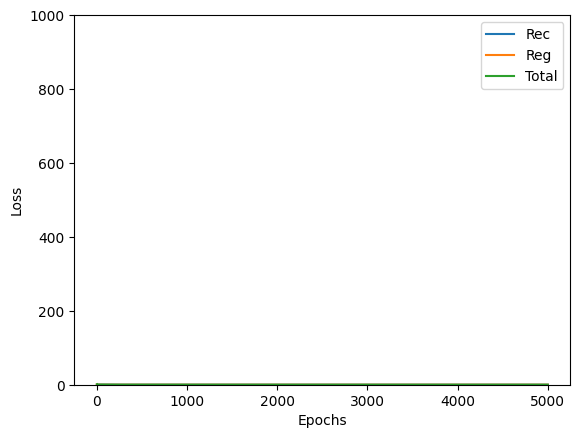

Model weights have been saved!


In [6]:
# 損失の可視化
visualize_loss(rec_error_record, reg_error_record, total_error_record)

# モデル保存
torch.save(vae.state_dict(), '/content/drive/MyDrive/chair/ISABVQVAE_Np5000_MSE_0320.pth')
print("Model weights have been saved!")

In [7]:
print(z_list) # z mu logvar

[array([[-0.33195597, -0.03494642, -0.23798065]], dtype=float32), array([[-0.28661093, -0.30902755,  0.06846024]], dtype=float32), array([[0.18087383, 0.312183  , 0.17420042]], dtype=float32), array([[ 0.11160133, -0.2841054 , -0.24219522]], dtype=float32), array([[ 0.2881128 , -0.00925343,  0.05790027]], dtype=float32), array([[ 0.21415253, -0.28996998,  0.3132866 ]], dtype=float32), array([[ 0.05347341,  0.13892126, -0.0656174 ]], dtype=float32), array([[-0.02043284,  0.05066596,  0.34967887]], dtype=float32), array([[ 0.05611505,  0.35655543, -0.31589797]], dtype=float32)]


# 再構成形状の可視化

torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])


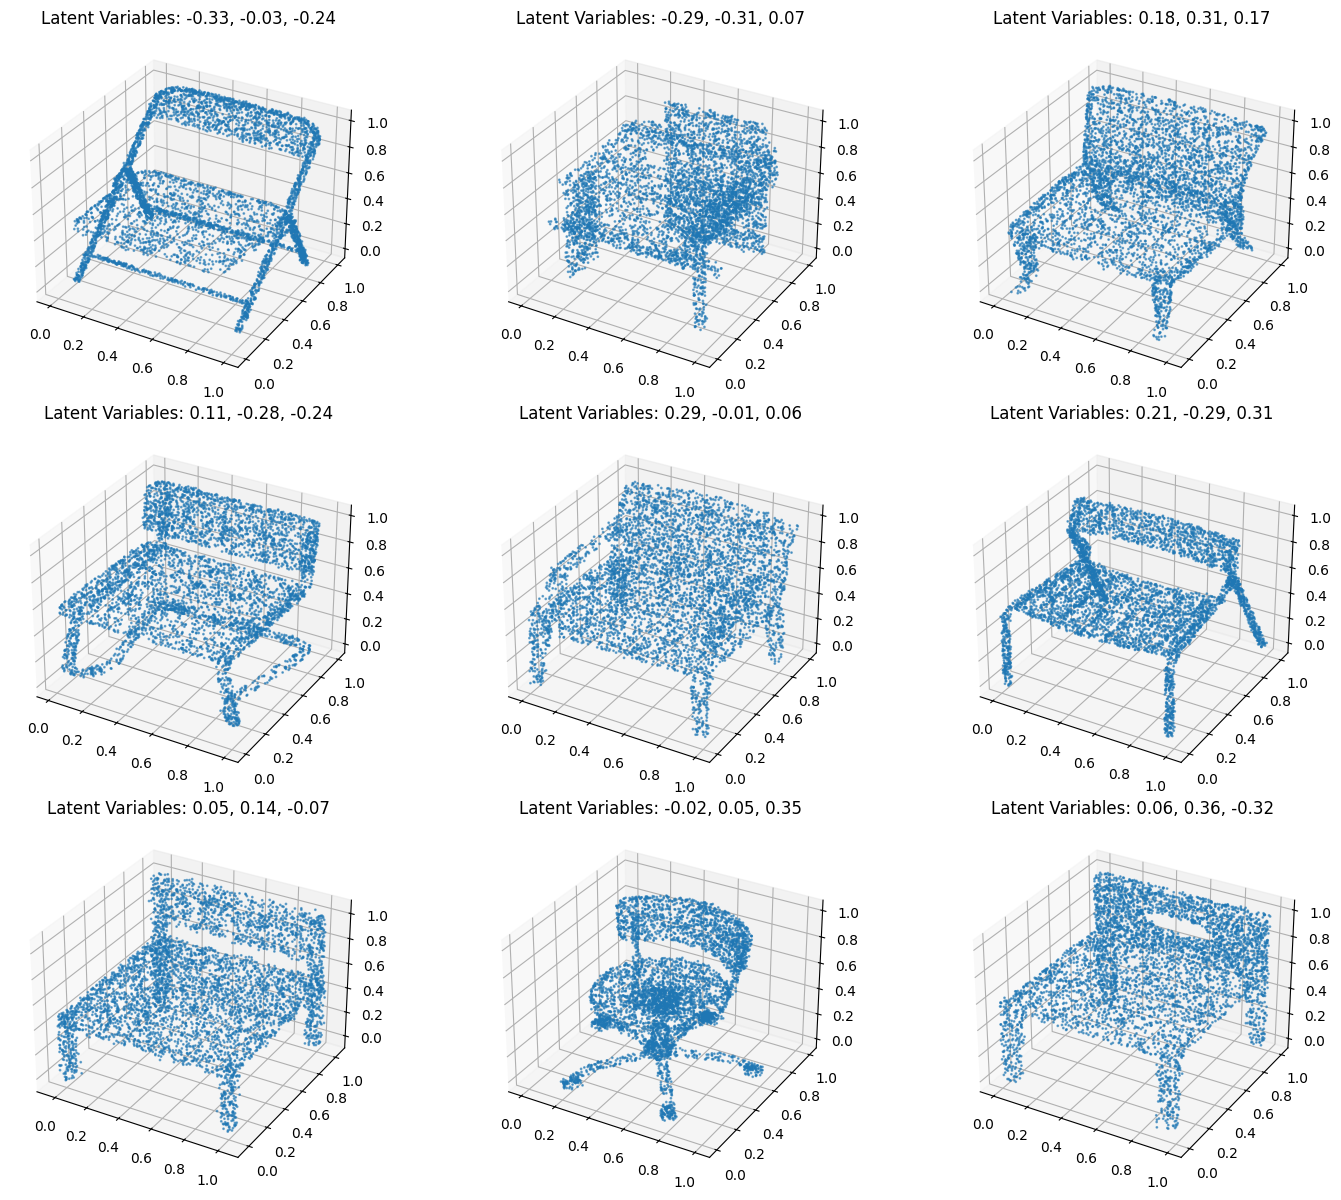

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# z_list_final.npy を読み込んで z_list に変換
z_array = np.load("z_list_final.npy")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
z_list = [torch.tensor(z_array[i], dtype=torch.float32).to(device) for i in range(z_array.shape[0])]

# 可視化用設定
num_points = 5000
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12), subplot_kw={'projection': '3d'})
axes = axes.flatten()

# 再構成と可視化
for index, z in enumerate(z_list):
    if index >= len(axes):
        break  # 9つのプロットで終了

    # 再構築 (z を 1バッチの形に変換して decode)
    recon_batch = vae.decode(z)  # z をバッチの形状に変換
    print(recon_batch.shape)

    # CPU上で detach して numpy に変換
    # デコード結果 recon_batch: (1, num_points, 3)
    reconst_np = recon_batch.squeeze(0).cpu().detach().numpy()  # -> (num_points, 3)

    # 各軸を列インデックスで取得
    reconst_x = reconst_np[:, 0]
    reconst_y = reconst_np[:, 1]
    reconst_z = reconst_np[:, 2]

    # プロット
    axes[index].scatter(reconst_x, reconst_y, reconst_z, s=1, alpha=0.6)

    # 潜在変数の値をフラット化してタイトルに表示
    z_flat = z.view(-1).tolist()  # 1次元化
    z_str = ", ".join([f"{value:.2f}" for value in z_flat])
    axes[index].set_title(f"Latent Variables: {z_str}")

# 最後にプロットを表示
plt.tight_layout()
plt.show()

# 再構成誤差チェック using CD

Chamfer Distances: [0.008421743288636208, 0.014791388064622879, 0.013961143791675568, 0.009785318747162819, 0.01493954099714756, 0.011797795072197914, 0.029927806928753853, 0.011448010802268982, 0.021929174661636353]
Average Chamfer Distance: 0.01522243581712246


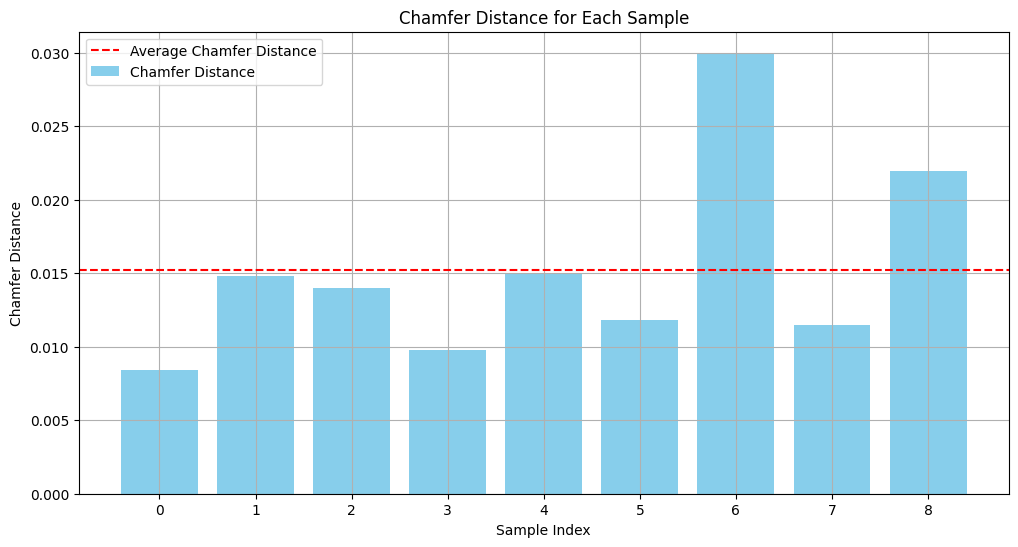

In [9]:
import torch
from torch.utils.data import DataLoader, TensorDataset
reconstructed_point_cloud=[]
# Chamfer Distanceの計算
chamfer_distances = []
for i, (x,) in enumerate(data_loader):
    x = x.to(device)
    x = x.squeeze(0)

    # Decode z_list[i]
    #z = torch.tensor(z_list[i]).to(device)
    recon_batch = vae.decode(z_list[i])
    # CPU上で detach して numpy に変換
    reconst_np = recon_batch.squeeze(0).cpu().detach().numpy()  # -> (num_points, 3)

    # 各軸を列インデックスで取得し、Tensor に変換
    reconst_x = torch.from_numpy(reconst_np[:, 0])
    reconst_y = torch.from_numpy(reconst_np[:, 1])
    reconst_z = torch.from_numpy(reconst_np[:, 2])

    # Tensor を stack して reconstructed_point_cloud を作成
    reconstructed_point_cloud = torch.stack([reconst_x, reconst_y, reconst_z], dim=-1).unsqueeze(0).to(device)


    # 元の点群の形状を整える
    original_point_cloud = x.reshape(1, num_points, 3).to(device)

    # カスタム関数でChamfer Distanceを計算
    loss_cd = chamfer_distance(original_point_cloud, reconstructed_point_cloud)
    chamfer_distances.append(loss_cd.item())

# Chamfer距離を出力
print("Chamfer Distances:", chamfer_distances)
average_chamfer_distance = sum(chamfer_distances) / len(chamfer_distances)
print(f"Average Chamfer Distance: {average_chamfer_distance}")

import matplotlib.pyplot as plt

# Chamfer Distancesの棒グラフをプロット
plt.figure(figsize=(12, 6))
plt.bar(range(len(chamfer_distances)), chamfer_distances, color='skyblue', label='Chamfer Distance')
plt.axhline(y=average_chamfer_distance, color='r', linestyle='--', label='Average Chamfer Distance')

# グラフの装飾
plt.title('Chamfer Distance for Each Sample')
plt.xlabel('Sample Index')
plt.ylabel('Chamfer Distance')
plt.xticks(range(len(chamfer_distances)))
plt.legend()
plt.grid(True)
plt.show()

# 再構成誤差チェック using EMD

EMD Distances: [0.004501771848737897, 0.007784242551467519, 0.007440533328598138, 0.005059124677031053, 0.007918344314421878, 0.006561228945922697, 0.020449104378086592, 0.006126478670508819, 0.012740447132012691]
Average EMD Distance: 0.008731252871865254


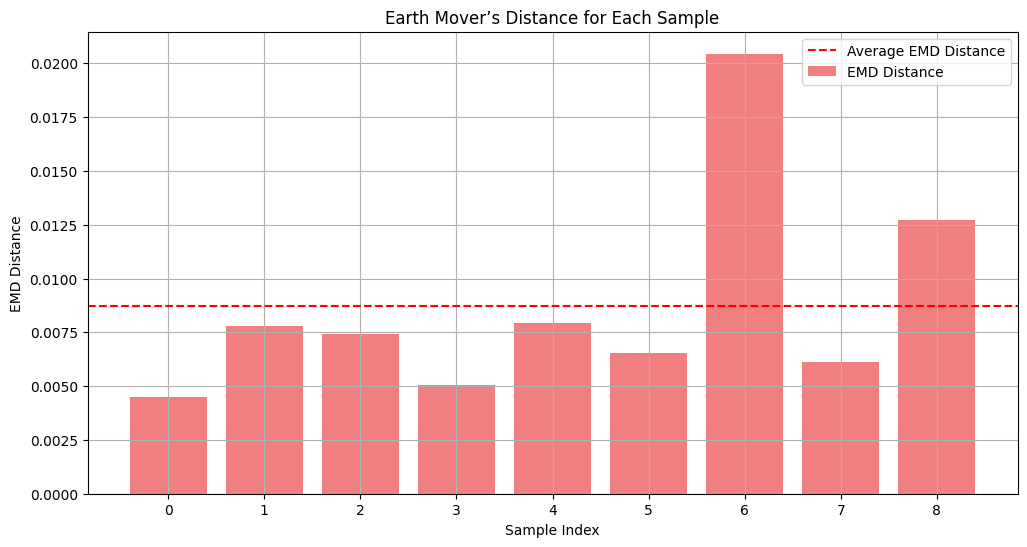

In [10]:
import torch
import ot  # Optimal Transportライブラリ
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# EMDの計算
emd_distances = []
reconstructed_point_cloud=[]
for i, (x,) in enumerate(data_loader):
    x = x.to(device)
    x = x.squeeze(0)

    # Decode z_list[i]
    #z = torch.tensor(z_list[i]).to(device)
    recon_batch = vae.decode(z_list[i])
    # CPU上で detach して numpy に変換
    reconst_np = recon_batch.squeeze(0).cpu().detach().numpy()  # -> (num_points, 3)

    # 各軸を列インデックスで取得し、Tensor に変換
    reconst_x = torch.from_numpy(reconst_np[:, 0])
    reconst_y = torch.from_numpy(reconst_np[:, 1])
    reconst_z = torch.from_numpy(reconst_np[:, 2])

    # Tensor を stack して reconstructed_point_cloud を作成
    reconstructed_point_cloud = torch.stack([reconst_x, reconst_y, reconst_z], dim=-1).unsqueeze(0).to(device)
    reconstructed_point_cloud = reconstructed_point_cloud.reshape(num_points, 3).to(device)


    # 元の点群の形状を整える
    original_point_cloud = x.reshape(num_points, 3).to(device)

    # カスタム関数でEMDを計算
    loss_emd = emd_distance(original_point_cloud, reconstructed_point_cloud)
    emd_distances.append(loss_emd)

# EMDの結果を出力
print("EMD Distances:", emd_distances)
average_emd_distance = sum(emd_distances) / len(emd_distances)
print(f"Average EMD Distance: {average_emd_distance}")

# EMDの棒グラフをプロット
plt.figure(figsize=(12, 6))
plt.bar(range(len(emd_distances)), emd_distances, color='lightcoral', label='EMD Distance')
plt.axhline(y=average_emd_distance, color='r', linestyle='--', label='Average EMD Distance')

# グラフの装飾
plt.title('Earth Mover’s Distance for Each Sample')
plt.xlabel('Sample Index')
plt.ylabel('EMD Distance')
plt.xticks(range(len(emd_distances)))
plt.legend()
plt.grid(True)
plt.show()